### Bidirectional LSTM CNN for NER

Code adapted from: https://github.com/mxhofer/Named-Entity-Recognition-BidirectionalLSTM-CNN-CoNLL
https://github.com/mxhofer/Named-Entity-Recognition-BidirectionalLSTM-CNN-CoNLL/blob/master/nn_CoNLL.ipynb

In [1]:
import numpy as np
import keras
from keras.models import Model, load_model
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, Flatten, concatenate
from keras.utils import plot_model
from keras.initializers import RandomUniform
from keras.optimizers import SGD, Nadam
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
keras.__version__

'2.1.6'

In [3]:
CASE_NUMERIC = 'numeric'
CASE_LOWER = 'all_lower'
CASE_UPPER = 'all_upper'
CASE_INITIAL_UPPER = 'initial_upper'
CASE_OTHER = 'other'
CASE_MAIN_NUMERIC = 'mainly_numeric'
CASE_CONTAIN_DIGIT = 'contains_digit'
CASE_PADDING = 'padding_token'

CASE_IDX = {CASE_NUMERIC:0, CASE_LOWER:1, CASE_UPPER:2, CASE_INITIAL_UPPER:3, CASE_OTHER:4, CASE_MAIN_NUMERIC:5, CASE_CONTAIN_DIGIT:6, CASE_PADDING:7}

In [4]:
def read_file(file_name):
    """ return format 
    [ ['EU', 'B-ORG'], ['rejects', 'O'], ['German', 'B-MISC'] ...]
    """
    sentences = []
    sent = []
    
    f = open(file_name, 'r')
    for line in f:
        line = line.replace('\n', '')
        if len(line)== 0 or line.startswith('-DOCSTART') or line=='\n':
            if len(sent) > 0:
#                 print(sent)
                sentences.append(sent)
                sent = []
            continue
            
        words = line.split(' ')
        sent.append([words[0], words[-1]])

    if len(sent)>0:
        sentences.append(sent)
        sent = []
    return sentences

sample_sents = read_file('/Users/grace/workspace/bio_dataset/CONLL2003/train.txt')

In [5]:
list(filter(lambda x: len(x)==0, sample_sents))
# sample_sents

[]

In [6]:
def add_char_info(sentences):
    """ return in format
    [ ['EU', ['E', 'U'], 'B-ORG'], ['rejects', ['r', 'e', 'j', 'e', 'c', 't', 's'], 'O'], ...]
    """
    for i, sent in enumerate(sentences):
        for j, data in enumerate(sent):
            chars = [c for c in data[0]]
            sentences[i][j] = [data[0], chars, data[1]]
    return sentences

sample_sents = add_char_info(sample_sents)
sample_sents[:2]

[[['EU', ['E', 'U'], 'B-ORG'],
  ['rejects', ['r', 'e', 'j', 'e', 'c', 't', 's'], 'O'],
  ['German', ['G', 'e', 'r', 'm', 'a', 'n'], 'B-MISC'],
  ['call', ['c', 'a', 'l', 'l'], 'O'],
  ['to', ['t', 'o'], 'O'],
  ['boycott', ['b', 'o', 'y', 'c', 'o', 't', 't'], 'O'],
  ['British', ['B', 'r', 'i', 't', 'i', 's', 'h'], 'B-MISC'],
  ['lamb', ['l', 'a', 'm', 'b'], 'O'],
  ['.', ['.'], 'O']],
 [['Peter', ['P', 'e', 't', 'e', 'r'], 'B-PER'],
  ['Blackburn', ['B', 'l', 'a', 'c', 'k', 'b', 'u', 'r', 'n'], 'I-PER']]]

In [7]:
def generate_char_dict():
    char2idx = {'PADDING':0, 'UNKNOWN':1}
    # all standard ascii chars
#     for i in range(128):
#         char2idx[chr(i)] = len(char2idx)
    for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
        char2idx[c] = len(char2idx)

    return char2idx

# generate_char_dict()

In [8]:
# case info such as NN can be used to learn patterns
def get_case_info(word, case_lookup):
    casing = CASE_OTHER
    
    num_digits = 0
    for char in word:
        if char.isdigit():
            num_digits += 1
    
    digit_fraction = num_digits / float(len(word))
    
    if word.isdigit():
        casing = CASE_NUMERIC
    elif digit_fraction > 0.5:
        casing = CASE_MAIN_NUMERIC
    elif num_digits > 0:
        casing = CASE_CONTAIN_DIGIT
    elif word.islower():
        casing = CASE_LOWER
    elif word.isupper():
        casing = CASE_UPPER
    elif word[0].isupper():
        casing = CASE_INITIAL_UPPER

    return case_lookup[casing]

get_case_info('am i 123 d989f8ds', CASE_IDX)
get_case_info('am i lower case sentences', CASE_IDX)
CASE_IDX

6

1

{'numeric': 0,
 'all_lower': 1,
 'all_upper': 2,
 'initial_upper': 3,
 'other': 4,
 'mainly_numeric': 5,
 'contains_digit': 6,
 'padding_token': 7}

In [9]:
def generate_matrices(sentences, word2idx, label2idx, case2idx, char2idx):
    unknown_idx = word2idx['UNKNOWN_TOKEN']
    padding_idx = word2idx['PADDING_TOKEN']
    
    dataset = []
    
    word_count = 0
    unknown_word_count = 0
    
    for sent in sentences:
        word_indices = []
        case_indices = []
        char_indices = []
        label_indices = []
        
        for word, char, label in sent:
            word_count += 1
            if word in word2idx:
                word_idx = word2idx[word]
            elif word.lower() in word2idx:
                word_idx = word2idx[word.lower()]
            else:
                word_idx = unknown_idx
                unknown_word_count += 1
                
            char_idx = []
            for x in char:
                char_idx.append(char2idx[x])
            
            #map label to int
            word_indices.append(word_idx)
            case_indices.append(get_case_info(word, case2idx))
            char_indices.append(char_idx)
            label_indices.append(label2idx[label])
        
        dataset.append([word_indices, case_indices, char_indices, label_indices])
        
    return dataset

# generate_matrices(sample_sents[:5], )

In [10]:
from keras.preprocessing.sequence import pad_sequences

def padding(sentences, max_len):
#     for sent in sentences:
#         char = sent[2]
        
#         for x in char:
#             max_len = max(max_len, len(x))
            
    for i, sent in enumerate(sentences):
        sentences[i][2] = pad_sequences(sentences[i][2], max_len, padding='post', value=0, dtype='int32')
    return sentences

# padding(sample_sents[0], MAX_LEN)

In [11]:
def generate_batches(data):
    l = []
    for i in data:
#         print(i[0])
        l.append(len(i[0]))
    
    l = set(l)
    
    batches = []
    batch_len = []
    
    z = 0
    for i in l:
        for batch in data:
            if len(batch[0])==i:
                batches.append(batch)
                z += 1
#         print(z)
        batch_len.append(z)
        
#     print(batches[0])
    return batches, batch_len

In [12]:
def iterate_mini_batches(dataset, batch_len):
#     print(dataset[0:2])
#     print(batch_len)
    start = 0
    for i in batch_len:
        tokens = []
        casing = []
        char = []
        labels = []
#         print(start)
        data = dataset[start:i]
        start = i

#         print(i)
#         print(data)
        
        for dt in data:
            t, c, ch, l = dt
#             print(l)
            l = np.expand_dims(l, -1)
            tokens.append(t)
            casing.append(c)
            char.append(ch)
            labels.append(l)
        
#         print(tokens)
        yield np.asarray(labels), np.asarray(tokens), np.asarray(casing), np.asarray(char)

In [13]:
iterate_mini_batches(sample_sents[:5], 2)

<generator object iterate_mini_batches at 0x1352a51b0>

In [14]:
def compute_precision(pred_sentences, correct_sentences):
    assert(len(pred_sentences)==len(correct_sentences))
    correct_count = 0
    count = 0
    
    for sent_idx in range(len(pred_sentences)):
        pred = pred_sentences[sent_idx]
        correct = correct_sentences[sent_idx]
        assert(len(pred)==len(correct))
        
        idx = 0
        while idx < len(pred):
            if pred[idx][0]=='B': # start of a new chunk
                count += 1
                
                if pred[idx]==correct[idx]: #first prediction correct
                    idx += 1
                    correctly_predicted = True
                    
                    while idx < len(pred) and pred[idx][0]=='I': #check entire chunk
                        if pred[idx] != correct[idx]:
                            correctly_predicted = False
                        idx +=1 
                        
                    if idx < len(pred):
                        if correct[idx][0]=='I': #correct chunk is longer
                            correctly_predicted = False
                    
                    if correctly_predicted:
                        correct_count += 1
                        
                else:
                    idx +=1
            else:
                idx += 1
                
                
    precision = 0
    if count > 0:
        precision = float(correct_count) / count
    
    return precision

In [15]:
def compute_f1(predictions, correct, idx2label):
    """compute accuracy"""
    pred_labels = []
    for sent in predictions:
        pred_labels.append([idx2label[ele] for ele in sent])
        
    correct_labels = []
    for sent in correct:
        correct_labels.append([idx2label[ele] for ele in sent])
    
    prec = compute_precision(pred_labels, correct_labels)
    rec = compute_precision(correct_labels, pred_labels)
    
    f1 = 0
    if (rec + prec) > 0:
        f1 = 2.0 * prec * rec / (prec + rec)
    
    return prec, rec, f1

In [16]:
def embed_gloVe(glove_loc, words):
    word2idx = {}
    word_embeddings = []

    f_embeddings = open(glove_loc, encoding='utf-8')

    for line in f_embeddings:
        sp_l = line.strip().split(' ')
        word = sp_l[0] #embedding word entry

        if len(word2idx)==0: #add padding + unknown
            word2idx['PADDING_TOKEN'] = len(word2idx)
            vector = np.zeros(len(sp_l)-1) #zero vector for padding
            word_embeddings.append(vector)

            word2idx['UNKNOWN_TOKEN'] = len(word2idx)
            vector = np.random.uniform(-0.25, 0.25, len(sp_l)-1)
            word_embeddings.append(vector)

        if sp_l[0].lower() in words:
            vector = np.array([float(num) for num in sp_l[1:]])
            word_embeddings.append(vector) #word embedding vector
            word2idx[sp_l[0]] = len(word2idx) #word dict
#     print(list(word2idx.keys())[:5])
    return np.array(word_embeddings), word2idx

In [17]:
# object mentioned to compatibility with 2.x
class CNN_BLSTM(object):
    
    def __init__(self, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER):
        self.epochs = EPOCHS
        self.dropout = DROPOUT
        self.dropout_recurrent = DROPOUT_RECURRENT
        self.lstm_state_size = LSTM_STATE_SIZE
        self.conv_size = CONV_SIZE
        self.learning_rate = LEARNING_RATE
        self.optimizer = OPTIMIZER
        
    def load_data(self, file_locs):
        """Load data"""
        train_loc = file_locs['train']
        dev_loc = file_locs['dev']
        test_loc = file_locs['test']
        
        self.trans_sentences = read_file(train_loc)
        self.dev_sentences = read_file(dev_loc)
        self.test_sentences = read_file(test_loc)
        
    def add_char(self):
        """Add char information"""
        self.trans_sentences = add_char_info(self.trans_sentences)
        self.dev_sentences = add_char_info(self.dev_sentences)
        self.test_sentences = add_char_info(self.test_sentences)
            
    def embed(self, glove_loc):
        """word-
        and char- level embeddings
        """
        
        #distinct labels
        label_set = set()
        #distinct tokens
        words = {}
        
        for dataset in [self.trans_sentences, self.dev_sentences, self.test_sentences]:
            for sent in dataset:
                # ['EU', ['E', 'U'], 'B-ORG']
                for token, char, label in sent:
                    label_set.add(label)
                    words[token.lower()] = True

        # mapping for label
        self.label2idx = {}
        for idx, label in enumerate(label_set):
            self.label2idx[label] = idx
        
        # mapping for char
        case2idx = CASE_IDX
        self.case_embeddings = np.identity(len(case2idx), dtype='float32')
        
        #apply GloVe embedding
        self.word_embeddings, word2idx = embed_gloVe(glove_loc, words)
        
        #build dictionary for all chars
        self.char2idx = generate_char_dict()
        
        #format : [[word indices], [case indices], [padded word indices], [label indices]]
        self.train_set = padding(generate_matrices(self.trans_sentences, word2idx, self.label2idx, case2idx, self.char2idx), MAX_LEN)
        self.dev_set = padding(generate_matrices(self.dev_sentences, word2idx, self.label2idx, case2idx, self.char2idx), MAX_LEN)
        self.test_set = padding(generate_matrices(self.test_sentences, word2idx, self.label2idx, case2idx, self.char2idx), MAX_LEN)
        
        self.idx2label = {v:k for k, v in self.label2idx.items()}
    
    def create_batches(self):
        self.train_batch, self.train_batch_len = generate_batches(self.train_set)
        self.dev_batch, self.dev_batch_len = generate_batches(self.dev_set)
        self.test_batch, self.test_batch_len = generate_batches(self.test_set)  
        
    def tag_dataset(self, dataset):
        """tag with numeric values"""
        correct_labels = []
        pred_labels = []

        for i, data in enumerate(dataset):
            tokens, casing, char, labels = data
            tokens = np.asarray([tokens])
            casing = np.asarray([casing])
            char = np.asarray([char])

            pred = self.model.predict([tokens, casing, char], verbose=False)[0]
            pred = pred.argmax(axis=1) #class

            correct_labels.append(labels)
            pred_labels.append(pred)

        return pred_labels, correct_labels

    def build_model(self):
        
        # char input
        char_input = Input(shape=(None, MAX_LEN,), name='char_input')
        embed_char_out = TimeDistributed(
            Embedding(len(self.char2idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_input)
        drop_out = Dropout(self.dropout)(embed_char_out)
        
        # CNN
        conv1d_out = TimeDistributed(Conv1D(kernel_size=self.conv_size, filters=30, padding='same', activation='tanh', strides=1), name='Convolution')(drop_out)
        maxpool_out = TimeDistributed(MaxPooling1D(MAX_LEN), name='Maxpool')(conv1d_out)
        char = TimeDistributed(Flatten(), name='Flatten')(maxpool_out)
        char = Dropout(self.dropout)(char)
        
        # word-level input
        words_input = Input(shape=(None,), dtype='int32', name='word_input')
        words = Embedding(input_dim=self.word_embeddings.shape[0], output_dim=self.word_embeddings.shape[1], weights=[self.word_embeddings], trainable=False)(words_input)
        
        # case-info input
        casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
        casing = Embedding(input_dim=self.case_embeddings.shape[0], output_dim=self.case_embeddings.shape[1], weights=[self.case_embeddings], trainable=False)(casing_input)
        
        # concat & Bidirectional LSTM
        output = concatenate([words, casing, char])
        #dropout - on input to each LSTM block
        #recurrent dropout - on recurrent input signal
        output = Bidirectional(LSTM(self.lstm_state_size, return_sequences=True, dropout=self.dropout, recurrent_dropout=self.dropout_recurrent), name='BLSTM')(output)
        output = TimeDistributed(Dense(len(self.label2idx), activation='softmax'), name='Softmax')(output)
        
        #model set up
        self.model = Model(inputs=[words_input, casing_input, char_input], outputs=[output])
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimizer)
        self.init_wegiths = self.model.get_weights()
        plot_model(self.model, to_file='./model.png')
        print('Model is built. Saved model.png\n')
        
    def train(self):
        self.f1_test_history = []
        self.f1_dev_history = []
        
        for epoch in range(self.epochs):
            print('Epoch {}/{}'.format(epoch+1, self.epochs))
            
#             print(self.train_batch[0])
            for batch in iterate_mini_batches(self.train_batch, self.train_batch_len):
                labels, tokens, casing, char = batch
#                 print(tokens)
                self.model.train_on_batch([tokens, casing, char], labels)
            
            #compute f1
            pred_labels, correct_labels = self.tag_dataset(self.test_batch)
            pre_test, rec_test, f1_test = compute_f1(pred_labels, correct_labels, self.idx2label)
            self.f1_test_history.append(round(f1_test, 4))
            print('F1 Test::: ', round(f1_test, 4))
            
            pred_labels, correct_labels = self.tag_dataset(self.dev_batch)
            pre_dev, rec_dev, f1_dev = compute_f1(pred_labels, correct_labels, self.idx2label)
            self.f1_dev_history.append(round(f1_dev, 4))
            print('F1 DEV::: ', round(f1_dev, 4), '\n')
        
        print('Final F1 test score: ', f1_test)
        print('Training Finished.')
        
        #save model
        self.model_name = "{}_{}_{}_{}_{}_{}_{}".format(self.epochs,
                                                       self.dropout,
                                                       self.dropout_recurrent,
                                                       self.lstm_state_size,
                                                       self.conv_size,
                                                       self.learning_rate,
                                                       self.optimizer.__class__.__name__)
        self.model.save(self.model_name+'.h5')
        print('Model Weights Saved.')
        
        self.model.set_weights(self.init_wegiths) #clear model
        print('Model Weights Cleared')
        
    def write_to_file(self):
        # .txt file format
        # [epoch]
        # [f1_test]
        # [f1_dev]
        
        ouput = np.matrix([[int(i) for i in range(self.epochs)], self.f1_test_history, self.f1_dev_history])
        with open(self.model_name+'.txt', 'wb') as f:
            for line in ouput:
                print(line[0])
#                 np.savetxt(f, str(line[0]), fmt='%.5f')
                
        print('Model performance written to file.')
    
    def plot_progress(self):
        fig, acc_ax = plt.subplots()
        
#         acc_ax = loss_ax.twinx()
        acc_ax.plot(self.f1_test_history, 'y', label='Test F1 Score')
        acc_ax.plot(self.f1_dev_history, 'r', label='Dev F1 Score')
        
        acc_ax.set_xlabel('epoch')
        acc_ax.set_ylabel('F1 Score')
        
        plt.show()
        
    print('Class initalized.')

Class initalized.


In [18]:
# parameters
EPOCHS = 50 #paper 80
DROPOUT = 0.5 #paper 0.68
DROPOUT_RECURRENT = 0.25 
LSTM_STATE_SIZE = 200 #paper 275
CONV_SIZE = 3 #paper 3
LEARNING_RATE = 0.0105 #paper 0.015
OPTIMIZER = Nadam() #paper SGD
MAX_LEN = 52

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model is built. Saved model.png

Epoch 1/50
Instructions for updating:
Use tf.cast instead.
F1 Test:::  0.3896
F1 DEV:::  0.4147 

Epoch 2/50
F1 Test:::  0.5956
F1 DEV:::  0.6441 

Epoch 3/50
F1 Test:::  0.6638
F1 DEV:::  0.7051 

Epoch 4/50
F1 Test:::  0.7442
F1 DEV:::  0.7714 

Epoch 5/50
F1 Test:::  0.7451
F1 DEV:::  0.7549 

Epoch 6/50
F1 Test:::  0.7606
F1 DEV:::  0.7892 

Epoch 7/50
F1 Test:::  0.7985
F1 DEV:::  0.8185 

Epoch 8/50
F1 Test:::  0.7949
F1 DEV:::  0.8101 

Epoch 9/50
F1 Test:::  0.8035
F1 DEV:::  0.8196 

Epoch 10/50
F1 Test:::  0.7997
F1 DEV:::  0.8134 

Epoch 11/50
F1 Test:::  0.817
F1 DEV:::  0.8312 

Epoch 12/50
F1 Test:::  0.8133
F1 DEV:::  0.8318 

Epoch 13/50
F1 Test:::  0.8316
F1 DEV:::  0.8489 

Epoch 14/50
F1 Test:::  0.8214
F1 DEV:::  0.8343 

Epoch 15/50
F1 Test:::  0.8284
F1 DEV:::  0.8429 

Epoch 16/50
F1 Test:::  0.8291
F1 DEV:::  0.8398 

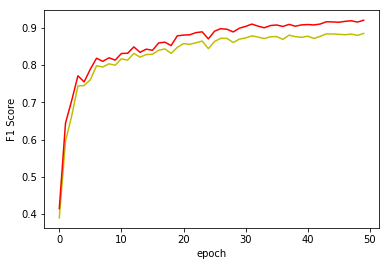

In [19]:
# Model Construction

FILE_LOCS = {'train':'/Users/grace/workspace/bio_dataset/CONLL2003/train.txt',
             'dev':'/Users/grace/workspace/bio_dataset/CONLL2003/valid.txt',
             'test':'/Users/grace/workspace/bio_dataset/CONLL2003/test.txt'}
GLOVE_LOC = '/Users/grace/workspace/embeddings/glove.6B/glove.6B.50d.txt'

cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.load_data(FILE_LOCS)
cnn_blstm.add_char()
cnn_blstm.embed(GLOVE_LOC)
cnn_blstm.create_batches()
cnn_blstm.build_model()
cnn_blstm.train()
cnn_blstm.write_to_file()
cnn_blstm.plot_progress()

In [30]:
#label distribution
category_count = {"B-ORG": 0, "I-ORG":0, "B-MISC": 0, "I-MISC":0, "B-LOC": 0, "I-LOC": 0, "B-PER": 0, "I-PER": 0, "O": 0}
total_count = 0

for sentence in cnn_blstm.trans_sentences:
    for word in sentence:
        if word[2] in category_count.keys():
            category_count[word[2]] += 1
            total_count += 1

In [31]:
for category, count in category_count.items():
    print("{}: {}%".format(category.replace("\n", ""), round((count/total_count)*100, 2)))

B-ORG: 3.1%
I-ORG: 1.82%
B-MISC: 1.69%
I-MISC: 0.57%
B-LOC: 3.51%
I-LOC: 0.57%
B-PER: 3.24%
I-PER: 2.22%
O: 83.28%
